In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Jan 31 12:21:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Conditional GAN

## Introduction to Normal GANs 
![](./markdown_img/GAN_Demo.png)

> A GAN contains a generator and a discriminator. A discriminator can be like a Convolutional Neural Network that tries to determine whether an image is real or fake. While doing so, the discriminator leaves behind a gradient that the generator can use to improve its own output. The generator competes with the discriminator and generates images. However when exploring simple GANs and looking at the output I noticed that the images was difficult to interpret or it seemed like the images was a little bit of an airplane and a little bit of a car.


# New section


## How CGAN or CDCGAN(Conditional Deep Convolutional GAN) can enhance output interpretability

![](./markdown_img/CGAN_Demo.png)

> CGAN is different from GAN where not only the pixels of real images are passed into the model , labels of each image is also passed in . As such the generator model generates images with a specific label
CDCGAN contains additional Convolutional transpose layers in the generator and Convolutional layers in the Discriminator  

image by Saul Dobilas https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8

# Conditional GANS
> The Generator and discriminator of the CGANs are conditioned on additional information such as class labels.

| Class Number      | Name |
| ----------- | ----------- |
| 0   | Airplane      |
| 1   | Automobile    |
| 2   | Bird      |
| 3   | Cat    |
| 4   | Deer      |
| 5   | Dog   |
| 6   | Frog      |
| 7   | Horse    |
| 8   | Ship      |
| 9   | Truck    |



## All required imports

In [ ]:
# DL modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
import keras.backend as K
from tensorflow.keras import initializers
! pip install tensorflow_addons
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.optimizers import Adam

# relevent libraries 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## matplotlib stylings
plt.rcParams['figure.figsize'] = 12, 8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.5 MB/s eta 0:00:00


## Constants and hyperparams

In [ ]:
batch_size = 128
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 128

In [ ]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])


# Conditional GAN takes in labels as the datasets 


In [ ]:
# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 127.5 - 1
all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


### Conditioning the CGAN to be able to produce class images
> We try to add the latent dimensions and the number of classes in the image so that we can condition the generator to be able to generate images based on classes. This is also true for the discriminator such that the discriminator that distinguish whether an image is fake and also the class of it.

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 13


## Model 1 

In [ ]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),
        SpectralNormalization(
        layers.Conv2D(32, kernel_size=4 , strides=2, padding="same"),
        ),
        layers.LeakyReLU(alpha=0.2),

        SpectralNormalization(
        layers.Conv2D(64, kernel_size=4 , strides=2, padding="same"),
        ),
        layers.LeakyReLU(alpha=0.2),
        SpectralNormalization(
        layers.Conv2D(128, kernel_size=4 , strides=2, padding="same"),
        ),
        SpectralNormalization(
        layers.Conv2D(256, kernel_size=4 , strides=2, padding="same"),
        ),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)



In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization_15 (  (None, 16, 16, 32)       6720      
 SpectralNormalization)                                          
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 spectral_normalization_16 (  (None, 8, 8, 64)         32896     
 SpectralNormalization)                                          
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 spectral_normalization_17 (  (None, 4, 4, 128)        131328    
 SpectralNormalization)                                          
                                                     

In [ ]:
# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(8 * 8 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (8, 8), padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8832)              1227648   
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8832)              0         
                                                                 
 reshape_10 (Reshape)        (None, 8, 8, 138)         0         
                                                                 
 conv2d_transpose_38 (Conv2D  (None, 16, 16, 128)      282752    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_39 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                              

# Classes

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        


    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [ ]:
class CONDGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=100, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.vmin = 0
        self.vmax = 1

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 75 == 0:
            # Save the model weights
            self.model.save_weights(f"/content/drive/MyDrive/Colab Notebooks/DELE_CA2/Models/CGAN/weights_epoch_{epoch + 1}.h5")
            
            # Plot the generated images
            num_classes = 10
            fig, axs = plt.subplots(num_classes, 10, figsize=(10, num_classes))

            for i in range(num_classes):
                class_label = keras.utils.to_categorical([i], num_classes)
                class_label = tf.cast(class_label, tf.float32)

                # Generate 10 random noise vectors
                random_noise = tf.random.normal(shape=(10, self.latent_dim))
                # Repeat the class label for each noise vector
                class_label = tf.repeat(class_label, repeats=10, axis=0)
                # Concatenate the noise and class label
                noise_and_label = tf.concat([random_noise, class_label], axis=1)
                # Run inference with the generator
                fake_images = self.model.generator(noise_and_label)
                fake_images = tf.image.convert_image_dtype(fake_images, dtype=tf.float32, saturate=True)
                
                # Plot the generated images
                for j in range(10):
                    axs[i, j].imshow(fake_images[j])
                    axs[i, j].set_title(f"Class: {i}")
                    axs[i, j].axis("off")
            plt.show()


## What is from_logits?

> logit is a type of function that maps probability from (0,1) to ( - inifinity , inifinity ) since I am using Sigmoid activation for Discriminator i will be setting from_logits to False

Epoch 1/500
469/469 [==============================] - 32s 65ms/step - g_loss: 2.5748 - d_loss: 0.7390
Epoch 2/500
468/469 [============================>.] - ETA: 0s - g_loss: 3.2424 - d_loss: 0.4489

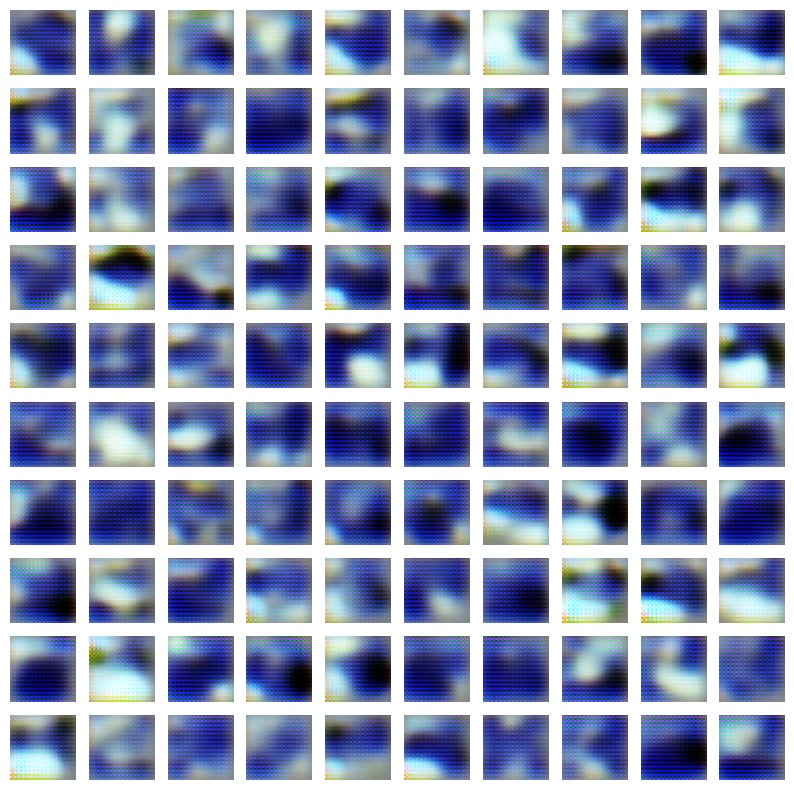

469/469 [==============================] - 31s 66ms/step - g_loss: 3.2433 - d_loss: 0.4490
Epoch 3/500
469/469 [==============================] - 30s 63ms/step - g_loss: 1.5572 - d_loss: 0.5313
Epoch 4/500
469/469 [==============================] - 30s 64ms/step - g_loss: 2.1542 - d_loss: 0.4961
Epoch 5/500
469/469 [==============================] - 30s 64ms/step - g_loss: 1.6244 - d_loss: 0.5708
Epoch 6/500
469/469 [==============================] - 30s 64ms/step - g_loss: 1.6355 - d_loss: 0.5787
Epoch 7/500
469/469 [==============================] - 31s 65ms/step - g_loss: 1.8072 - d_loss: 0.7063
Epoch 8/500
469/469 [==============================] - 31s 65ms/step - g_loss: 1.8938 - d_loss: 0.5365
Epoch 9/500
469/469 [==============================] - 31s 66ms/step - g_loss: 1.3063 - d_loss: 0.5735
Epoch 10/500
469/469 [==============================] - 31s 66ms/step - g_loss: 1.9733 - d_loss: 0.5438
Epoch 11/500
469/469 [==============================] - 31s 66ms/step - g_loss: 3.10

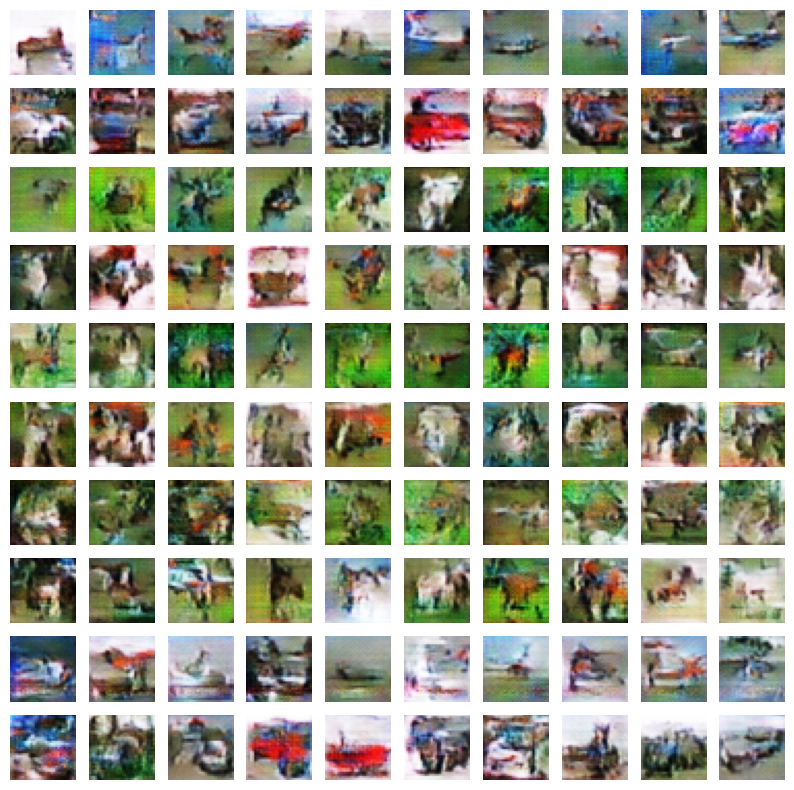

469/469 [==============================] - 34s 72ms/step - g_loss: 1.1736 - d_loss: 0.5769
Epoch 303/500
469/469 [==============================] - 31s 67ms/step - g_loss: 1.1307 - d_loss: 0.5768
Epoch 304/500
469/469 [==============================] - 31s 67ms/step - g_loss: 1.1041 - d_loss: 0.5796
Epoch 305/500
469/469 [==============================] - 31s 67ms/step - g_loss: 1.1081 - d_loss: 0.5691
Epoch 306/500
469/469 [==============================] - 32s 68ms/step - g_loss: 1.1321 - d_loss: 0.5708
Epoch 307/500
469/469 [==============================] - 32s 68ms/step - g_loss: 1.1689 - d_loss: 0.5659
Epoch 308/500
469/469 [==============================] - 32s 68ms/step - g_loss: 1.1892 - d_loss: 0.5833
Epoch 309/500
469/469 [==============================] - 32s 68ms/step - g_loss: 1.0565 - d_loss: 0.5787
Epoch 310/500
469/469 [==============================] - 32s 67ms/step - g_loss: 1.1730 - d_loss: 0.5617
Epoch 311/500
469/469 [==============================] - 32s 68ms/ste

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=128
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

con_hist = cond_gan.fit(dataset, epochs=500, callbacks=[CONDGANMonitor(num_img=100, latent_dim=128)])

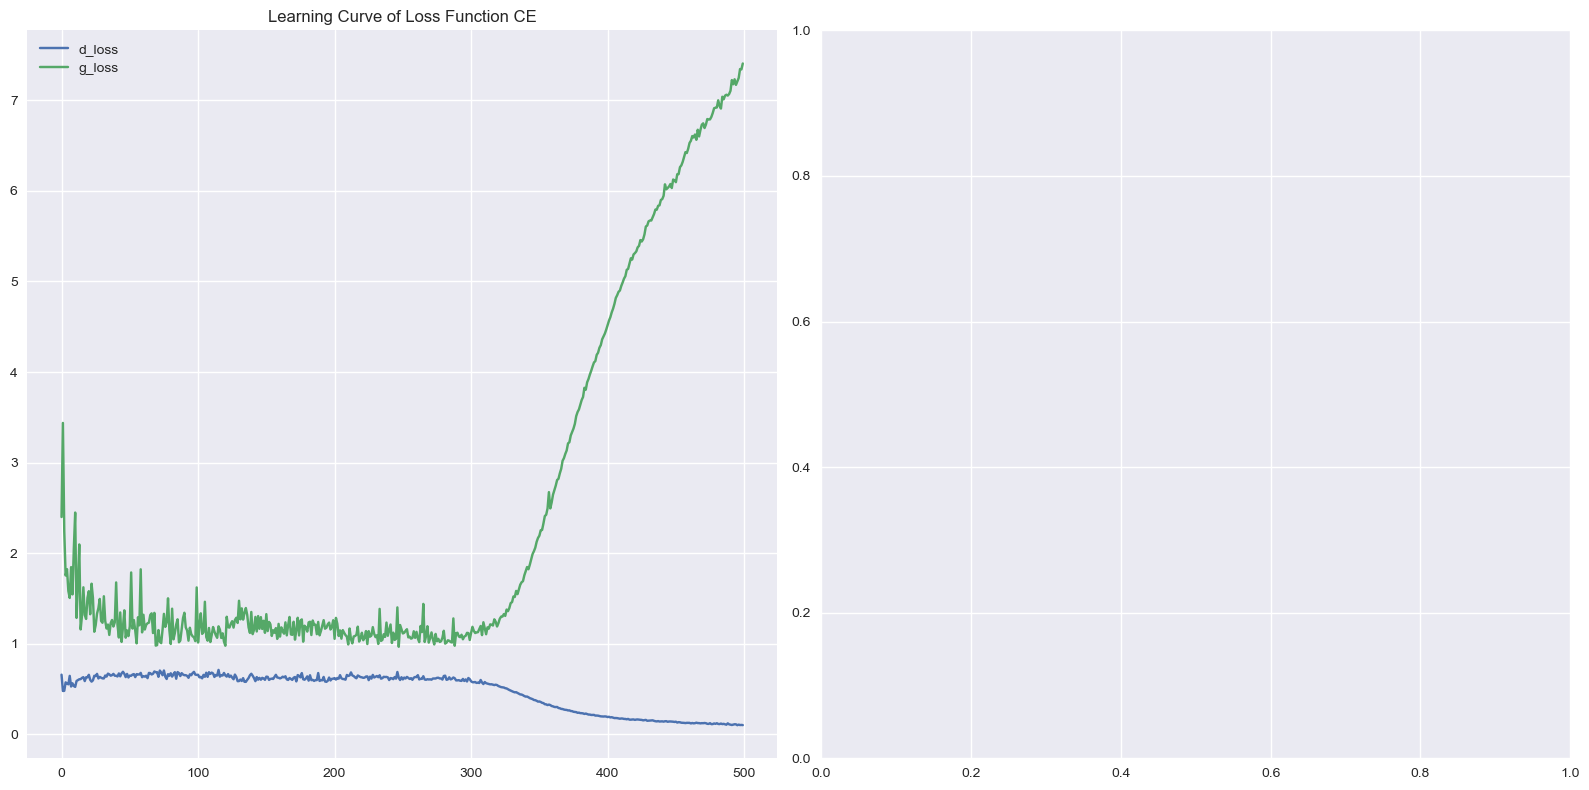

In [ ]:
# story history object into dataframe
hist_df = pd.DataFrame(con_hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    plt.show()


In [ ]:
tf.keras.models.save_model(generator , "./generator_cgan3.h5")

In [ ]:
tf.keras.models.save_model(discriminator , "./discriminator_cgan3.h5")

Epoch 1/1000
469/469 [==============================] - 29s 59ms/step - g_loss: 7.2806 - d_loss: 0.0968
Epoch 2/1000
468/469 [============================>.] - ETA: 0s - g_loss: 7.3500 - d_loss: 0.0911

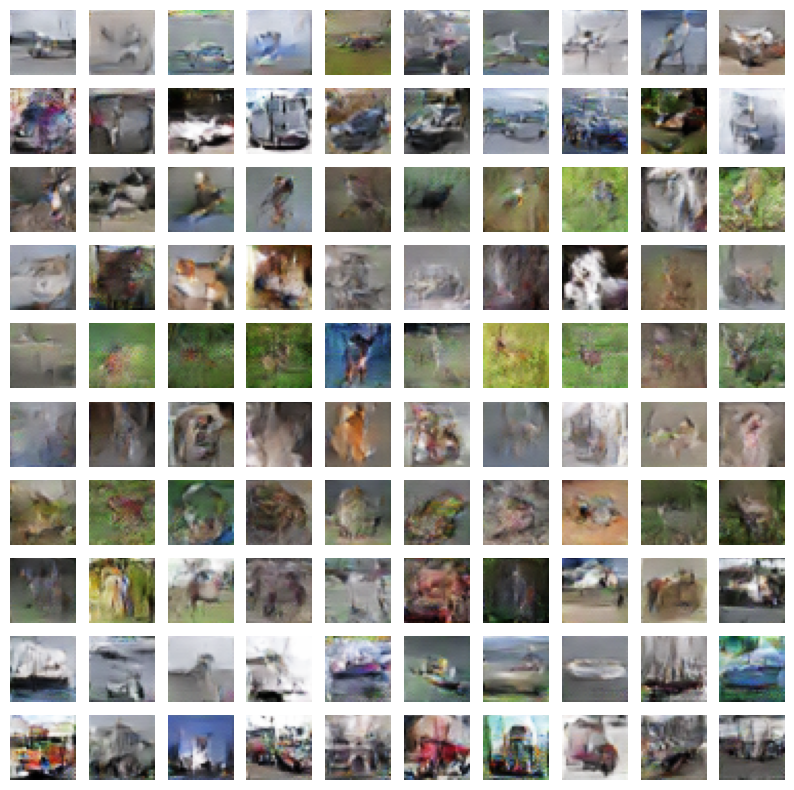

469/469 [==============================] - 29s 63ms/step - g_loss: 7.3499 - d_loss: 0.0911
Epoch 3/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.3813 - d_loss: 0.0830
Epoch 4/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.4428 - d_loss: 0.0788
Epoch 5/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.5195 - d_loss: 0.0794
Epoch 6/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.6054 - d_loss: 0.0762
Epoch 7/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.6070 - d_loss: 0.0779
Epoch 8/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.6992 - d_loss: 0.0698
Epoch 9/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.7475 - d_loss: 0.0698
Epoch 10/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 7.8132 - d_loss: 0.0700
Epoch 11/1000
469/469 [==============================] - 28s 59ms/step - g_l

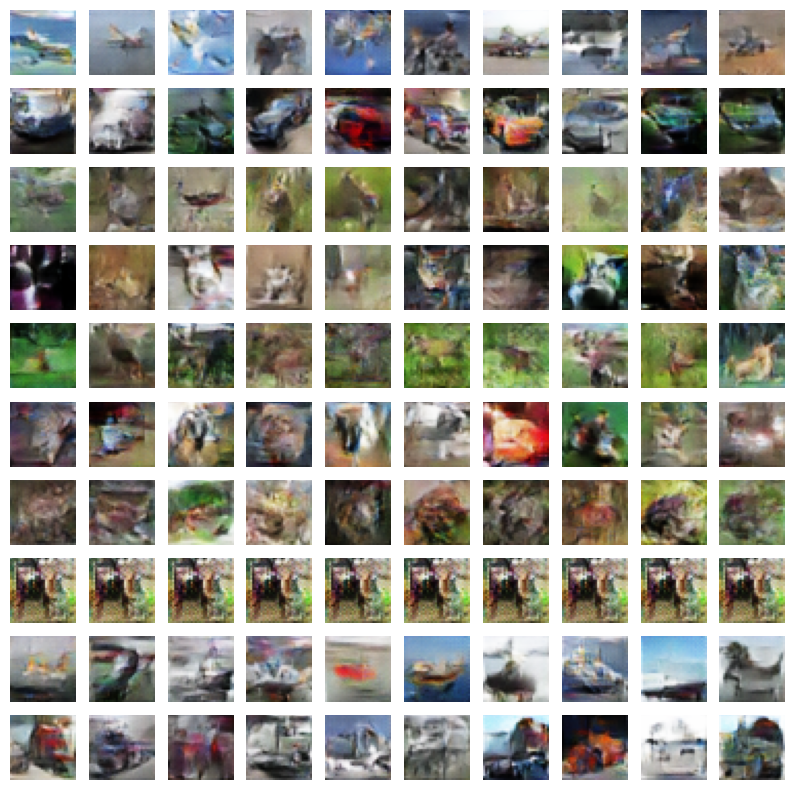

469/469 [==============================] - 30s 64ms/step - g_loss: 5.4903 - d_loss: 0.1552
Epoch 303/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.7500 - d_loss: 0.1496
Epoch 304/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.3841 - d_loss: 0.1883
Epoch 305/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.5062 - d_loss: 0.1570
Epoch 306/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.2939 - d_loss: 0.1739
Epoch 307/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.4079 - d_loss: 0.1653
Epoch 308/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.5243 - d_loss: 0.1525
Epoch 309/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.5411 - d_loss: 0.1543
Epoch 310/1000
469/469 [==============================] - 28s 59ms/step - g_loss: 5.4227 - d_loss: 0.1752
Epoch 311/1000
469/469 [==============================] - 28s

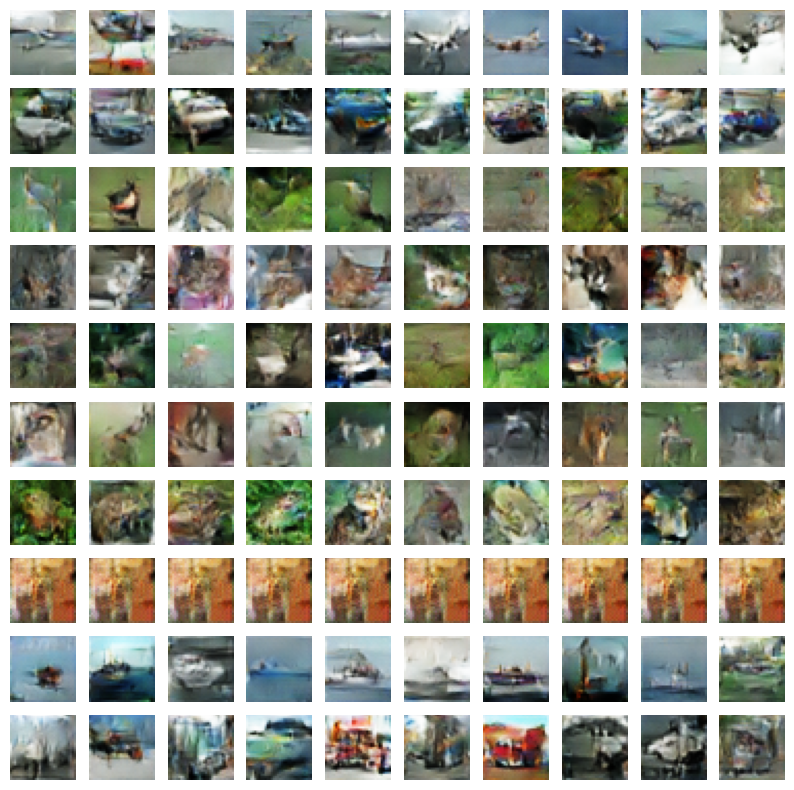

469/469 [==============================] - 34s 72ms/step - g_loss: 6.1798 - d_loss: 0.1491
Epoch 603/1000
469/469 [==============================] - 28s 61ms/step - g_loss: 6.0843 - d_loss: 0.1490
Epoch 604/1000
469/469 [==============================] - 41s 87ms/step - g_loss: 6.3712 - d_loss: 0.1342
Epoch 605/1000
469/469 [==============================] - 70s 149ms/step - g_loss: 6.3537 - d_loss: 0.1348
Epoch 606/1000
469/469 [==============================] - 89s 189ms/step - g_loss: 6.2632 - d_loss: 0.1308
Epoch 607/1000
469/469 [==============================] - 61s 129ms/step - g_loss: 6.5823 - d_loss: 0.1201
Epoch 608/1000
469/469 [==============================] - 63s 134ms/step - g_loss: 6.5377 - d_loss: 0.1192
Epoch 609/1000
469/469 [==============================] - 67s 142ms/step - g_loss: 6.5570 - d_loss: 0.1136
Epoch 610/1000
469/469 [==============================] - 62s 132ms/step - g_loss: 6.5061 - d_loss: 0.1291
Epoch 611/1000
469/469 [==============================]

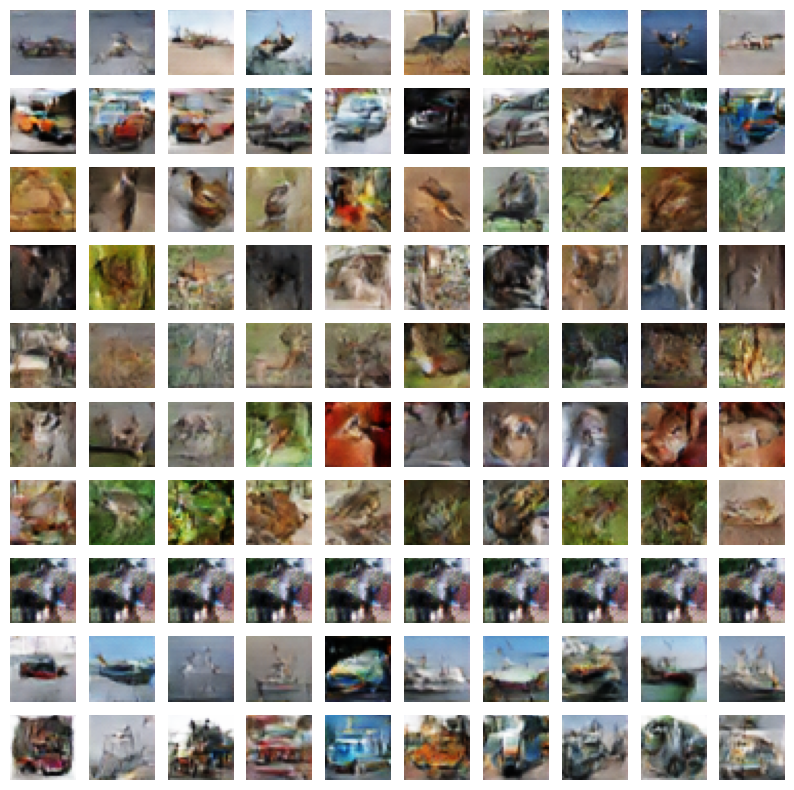

469/469 [==============================] - 57s 121ms/step - g_loss: 6.8845 - d_loss: 0.1150
Epoch 903/1000
469/469 [==============================] - 52s 111ms/step - g_loss: 6.9444 - d_loss: 0.1061
Epoch 904/1000
469/469 [==============================] - 52s 111ms/step - g_loss: 6.7442 - d_loss: 0.1120
Epoch 905/1000
469/469 [==============================] - 52s 112ms/step - g_loss: 6.6289 - d_loss: 0.1243
Epoch 906/1000
469/469 [==============================] - 52s 111ms/step - g_loss: 6.8849 - d_loss: 0.1114
Epoch 907/1000
469/469 [==============================] - 52s 110ms/step - g_loss: 6.8329 - d_loss: 0.1009
Epoch 908/1000
469/469 [==============================] - 53s 113ms/step - g_loss: 7.0307 - d_loss: 0.1110
Epoch 909/1000
469/469 [==============================] - 53s 112ms/step - g_loss: 7.0989 - d_loss: 0.0955
Epoch 910/1000
469/469 [==============================] - 52s 111ms/step - g_loss: 6.9492 - d_loss: 0.1084
Epoch 911/1000
469/469 [============================

In [ ]:
cond_gan2 = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=128
)
cond_gan2.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

con_hist2 = cond_gan2.fit(dataset, epochs=1000, callbacks=[CONDGANMonitor(num_img=100, latent_dim=138)])

In [ ]:
tf.keras.models.save_model(generator , "./generator_cgan4.h5")

In [ ]:
tf.keras.models.save_model(discriminator , "./discriminator_cgan4.h5")

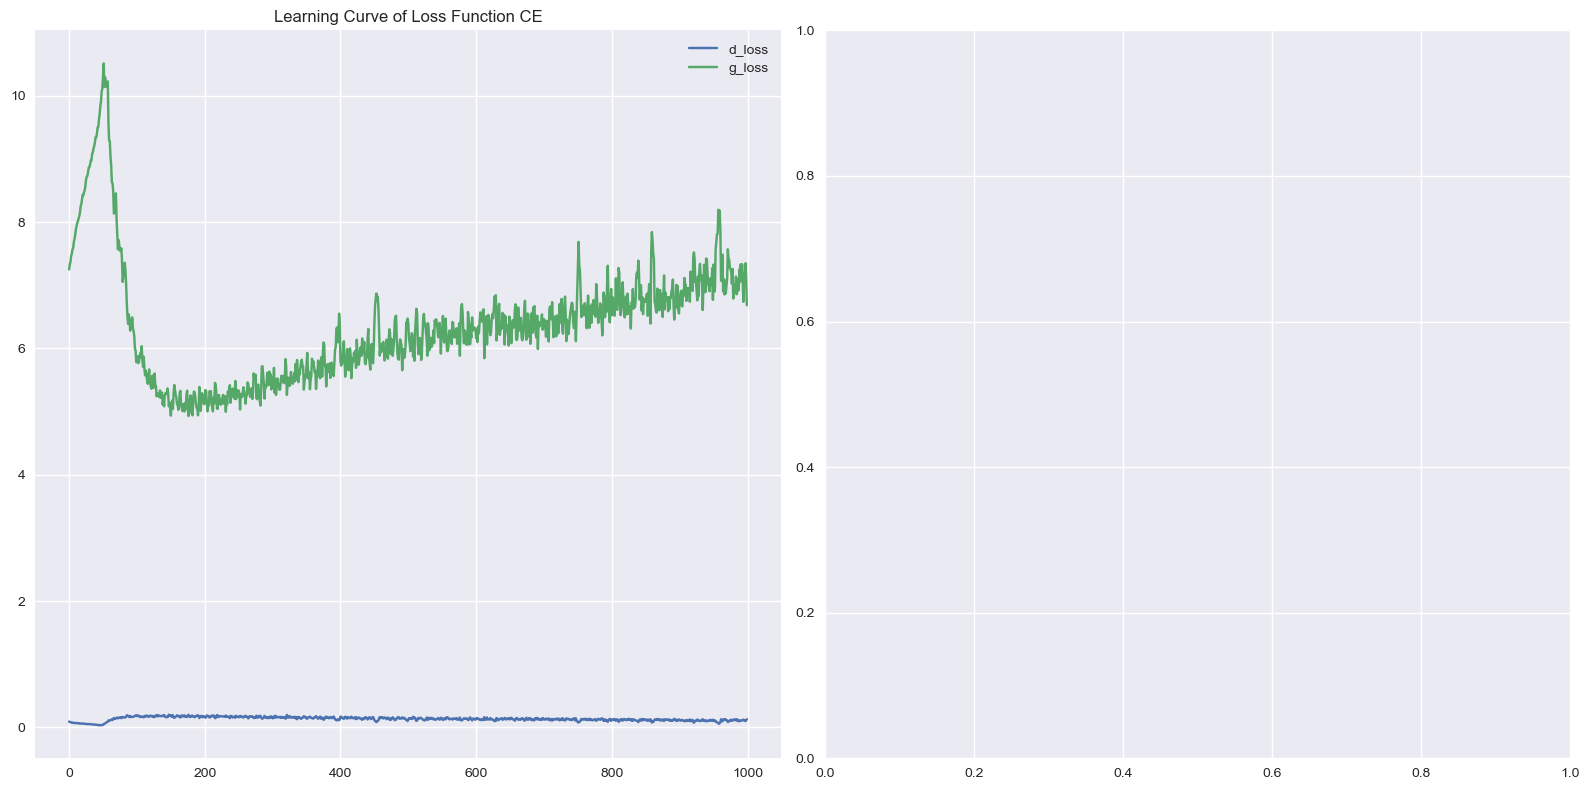

In [ ]:
# story history object into dataframe
hist_df = pd.DataFrame(con_hist2.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    plt.show()


In [ ]:
gen = tf.keras.models.load_model("./generator_cgan3.h5")
gen.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8832)              1227648   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 8832)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 138)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      282752    
 ranspose)                                                       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                               

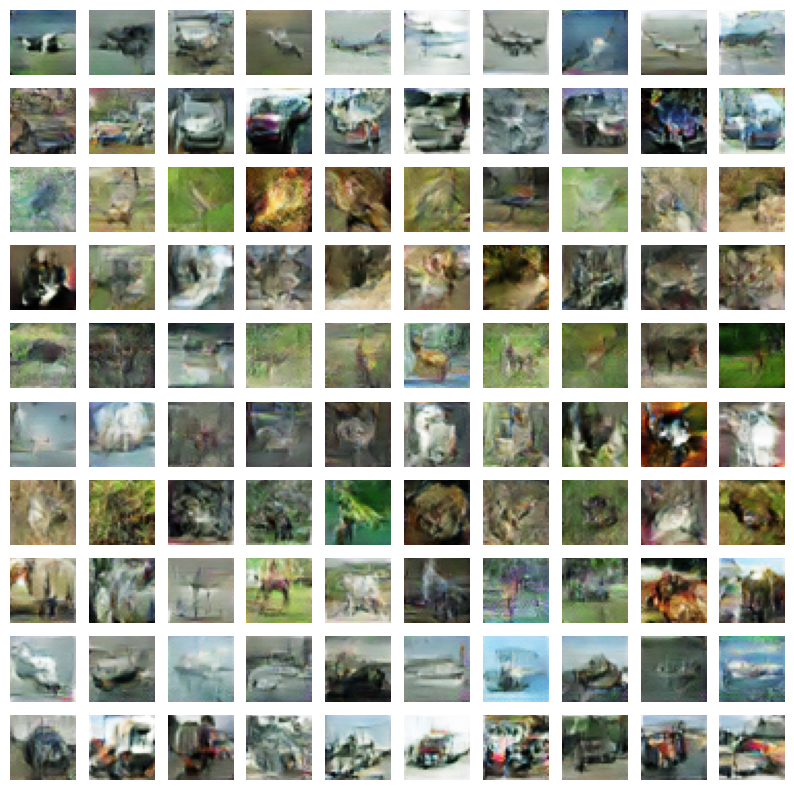

In [ ]:
# Get the trained generator
trained_gen = cond_gan.generator

num_classes = 10
fig, axs = plt.subplots(num_classes, 10, figsize=(10, num_classes))

for i in range(num_classes):
    class_label = keras.utils.to_categorical([i], num_classes)
    class_label = tf.cast(class_label, tf.float32)

    # Generate 10 random noise vectors
    random_noise = tf.random.normal(shape=(10, latent_dim))
    # Repeat the class label for each noise vector
    class_label = tf.repeat(class_label, repeats=10, axis=0)
    # Concatenate the noise and class label
    noise_and_label = tf.concat([random_noise, class_label], axis=1)
    # Run inference with the generator
    fake_images = trained_gen(noise_and_label)

    fake_images -= -1
    fake_images /= (1 - -1)
    
    # Plot the generated images
    for j in range(10):
        axs[i, j].imshow(fake_images[j])
        axs[i, j].axis("off")

plt.show()

# Handling Representation Scarcity
# Data augmentation generates more data by applying the features below to the dataset
## i will only apply this features as I think they will help the model 
- Rotation
- Flip

In [ ]:
# import dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# We'll use all the available examples from both the training and test
# sets.
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.


all_digits = all_digits.astype("float32") / 127.5 - 1




170498071/170498071 [==============================] - 3s 0us/step


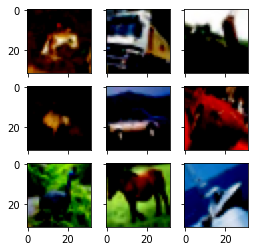

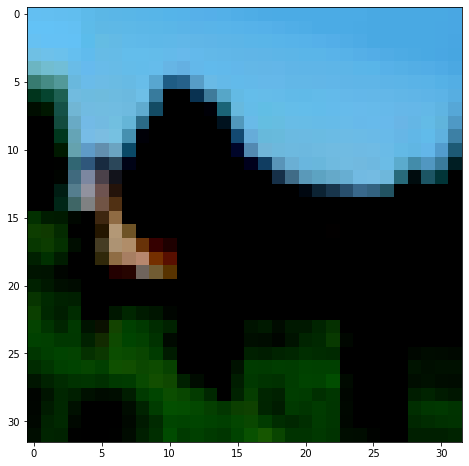

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

all_digits_rotate = all_digits.copy()
all_labels_rotate = all_labels.copy()

# define data preparation
datagen = ImageDataGenerator(rotation_range=30)
# fit parameters from data
datagen.fit(all_digits_rotate)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(all_digits_rotate, all_labels_rotate, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

all_digits_rotated = datagen.flow(all_digits_rotate, all_labels_rotate, batch_size=all_digits_rotate.shape[0], shuffle=False).next()
all_digits_rotated = all_digits_rotated[0]



plt.imshow(all_digits_rotated[12])
plt.show()


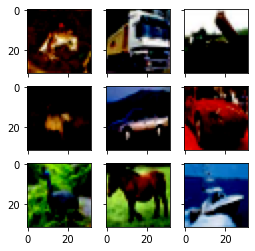

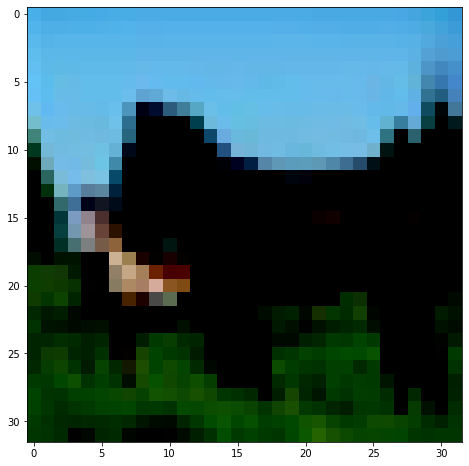

In [ ]:
all_digits_flip = all_digits.copy()
all_labels_flip = all_labels.copy()

# define data preparation
datagen = ImageDataGenerator(horizontal_flip=True)

# fit parameters from data
datagen.fit(all_digits_flip)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(all_digits_flip, all_labels_flip, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

all_digits_flipped = datagen.flow(all_digits_flip, all_labels_flip, batch_size=all_digits_flip.shape[0], shuffle=False).next()
all_digits_flipped = all_digits_flipped[0]



plt.imshow(all_digits_flip[12])
plt.show()





In [ ]:
# concat flip shift and rotate
all_digits = np.concatenate((all_digits,all_digits_flipped,all_digits_rotated),axis=0)
all_labels = np.concatenate((all_labels,all_labels_flip,all_labels_rotate),axis=0)
print('total data points after adding all:',all_digits.shape, all_labels.shape)

total data points after adding all: (180000, 32, 32, 3) (180000, 1)


In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 13


## Converting to tensors

In [ ]:

#  one-hot encode the labels.
all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Maximal pixel value: {np.max(all_digits)}")
print(f"Minimal pixel value: {np.min(all_digits)}")

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Maximal pixel value: 1.0
Minimal pixel value: -1.0
Shape of training images: (180000, 32, 32, 3)
Shape of training labels: (180000, 10)


In [ ]:
# all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
# all_labels = keras.utils.to_categorical(all_labels, 10)

# # Create tf.data.Dataset.
# dataset = tf.data.Dataset.from_tensor_slices((all_digits,all_labels))
# dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# print(f"Maximal pixel value: {np.max(all_digits)}")
# print(f"Minimal pixel value: {np.min(all_digits)}")

# print(f"Shape of training images: {all_digits.shape}")
# print(f"Shape of training labels: {all_labels.shape}")



# print('Dataset Loaded')

Maximal pixel value: 1.0
Minimal pixel value: -1.0
Shape of training images: (180000, 32, 32, 3)
Shape of training labels: (180000, 10, 10)
Dataset Loaded


In [ ]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),
        SpectralNormalization(
        layers.Conv2D(64, kernel_size=4 , strides=2, padding="same"),
        ),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),

        SpectralNormalization(
        layers.Conv2D(128, kernel_size=4 , strides=2, padding="same"),
        ),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(alpha=0.2),
        SpectralNormalization(
        layers.Conv2D(256, kernel_size=4 , strides=2, padding="same"),
        ),
        layers.BatchNormalization(momentum=0.8),
        SpectralNormalization(
        layers.Conv2D(256, kernel_size=4 , strides=2, padding="same"),
        ),
     
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization_19 (  (None, 16, 16, 64)       13440     
 SpectralNormalization)                                          
                                                                 
 batch_normalization_50 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 spectral_normalization_20 (  (None, 8, 8, 128)        131328    
 SpectralNormalization)                                          
                                                                 
 batch_normalization_51 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                    

In [ ]:
# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(2 * 2 * generator_in_channels),
        layers.ReLU(),
        layers.Reshape((2, 2, generator_in_channels)),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.ReLU(),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.ReLU(),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.ReLU(),
        layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.ReLU(),
        layers.Conv2D(3, (4, 4), padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 552)               76728     
                                                                 
 re_lu_48 (ReLU)             (None, 552)               0         
                                                                 
 reshape_11 (Reshape)        (None, 2, 2, 138)         0         
                                                                 
 conv2d_transpose_40 (Conv2D  (None, 4, 4, 64)         141376    
 Transpose)                                                      
                                                                 
 batch_normalization_53 (Bat  (None, 4, 4, 64)         256       
 chNormalization)                                                
                                                                 
 re_lu_49 (ReLU)             (None, 4, 4, 64)          0 

## Final fit

## Added Label smoothing

In [49]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=128
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
)

con_hist = cond_gan.fit(dataset, epochs=1000, callbacks=[CONDGANMonitor(num_img=100)])

Output hidden; open in https://colab.research.google.com to view.

# Mode collapse happened 

In [50]:
# story history object into dataframe
hist_df = pd.DataFrame(con_hist.history)

# using pandas dataframe to plot out learning curve
with plt.style.context('seaborn'):
    fig, (ax1, ax2) = plt.subplots(1,1, figsize=(16, 8), tight_layout=True)
    hist_df.loc[:, ["d_loss", 'g_loss']].plot(ax=ax1, title=r'Learning Curve of Loss Function CE')
    plt.show()


NameError: ignored